# Sentiment Analysis using SVM

### 1. Data Loading and Description

In [9]:
import pandas as pd

data = pd.read_csv('/kaggle/input/financial-tweets/finance_tweets_sentiment_HF.csv', encoding = 'latin1', header = 0)
#https://www.kaggle.com/datasets/drivebackup/financial-tweets/versions/1
data.head()

,news,sentiment_hf
0,"According to Gran , the company has no plans t...",neutral
1,Technopolis plans to develop in stages an area...,neutral
2,The international electronic industry company ...,negative
3,With the new production plant the company woul...,positive
4,According to the company 's updated strategy f...,positive


In [10]:
data.describe()

,news,sentiment_hf
count,4846,4846
unique,4838,3
top,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...,neutral
freq,2,2820


In [11]:
# Check for missing values
missing_values = data.isnull().sum()

# Drop duplicate rows
data = data.drop_duplicates()

missing_values, len(data)

(news            0
 sentiment_hf    0
 dtype: int64,
 4838)

### Data Visualization

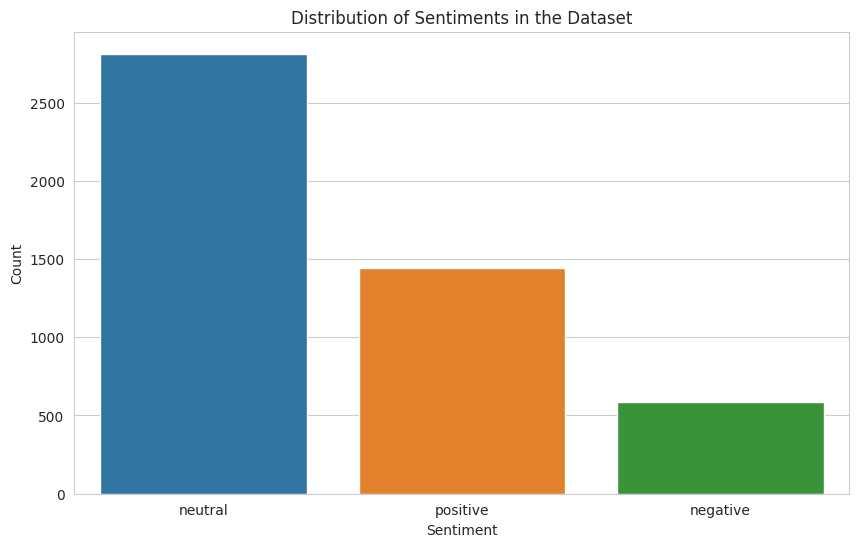

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Plot the distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='sentiment_hf', order=data['sentiment_hf'].value_counts().index)
plt.title("Distribution of Sentiments in the Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

The distribution of sentiments gives us an idea of the balance between the classes.

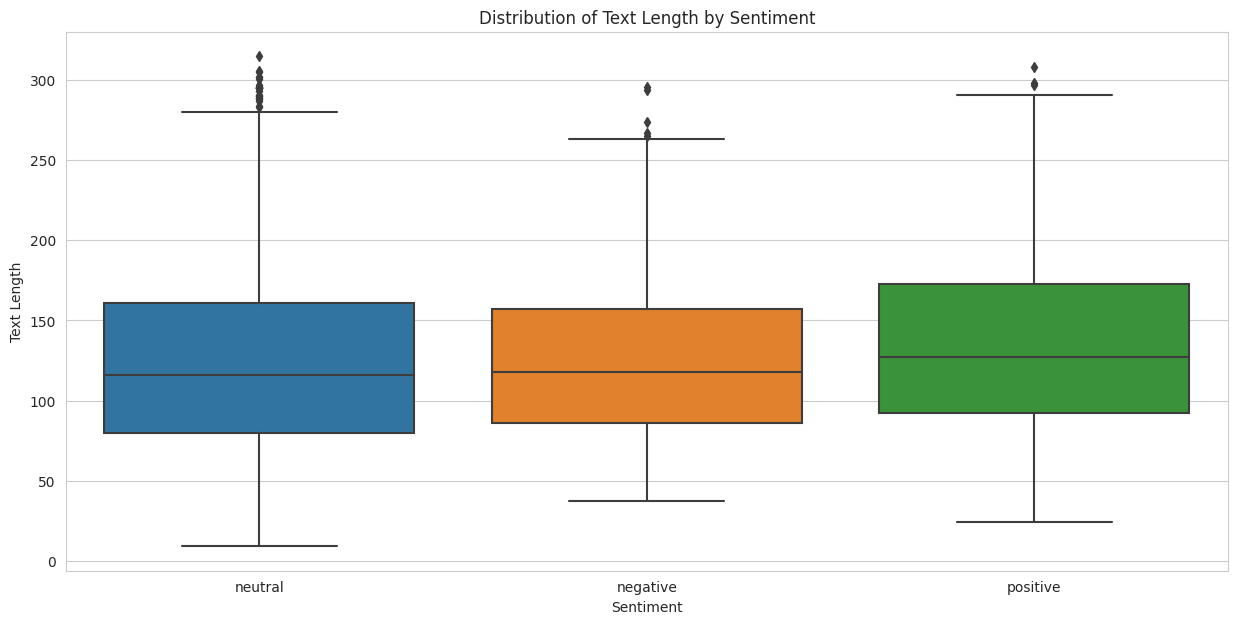

In [13]:
data['text_length'] = data['news'].apply(len)

plt.figure(figsize=(15, 7))
sns.boxplot(data=data, x='sentiment_hf', y='text_length')
plt.title("Distribution of Text Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Text Length")
plt.show()


The distribution of text length for each sentiment class helps us understand if there's any relation between the length of the text and its sentiment.

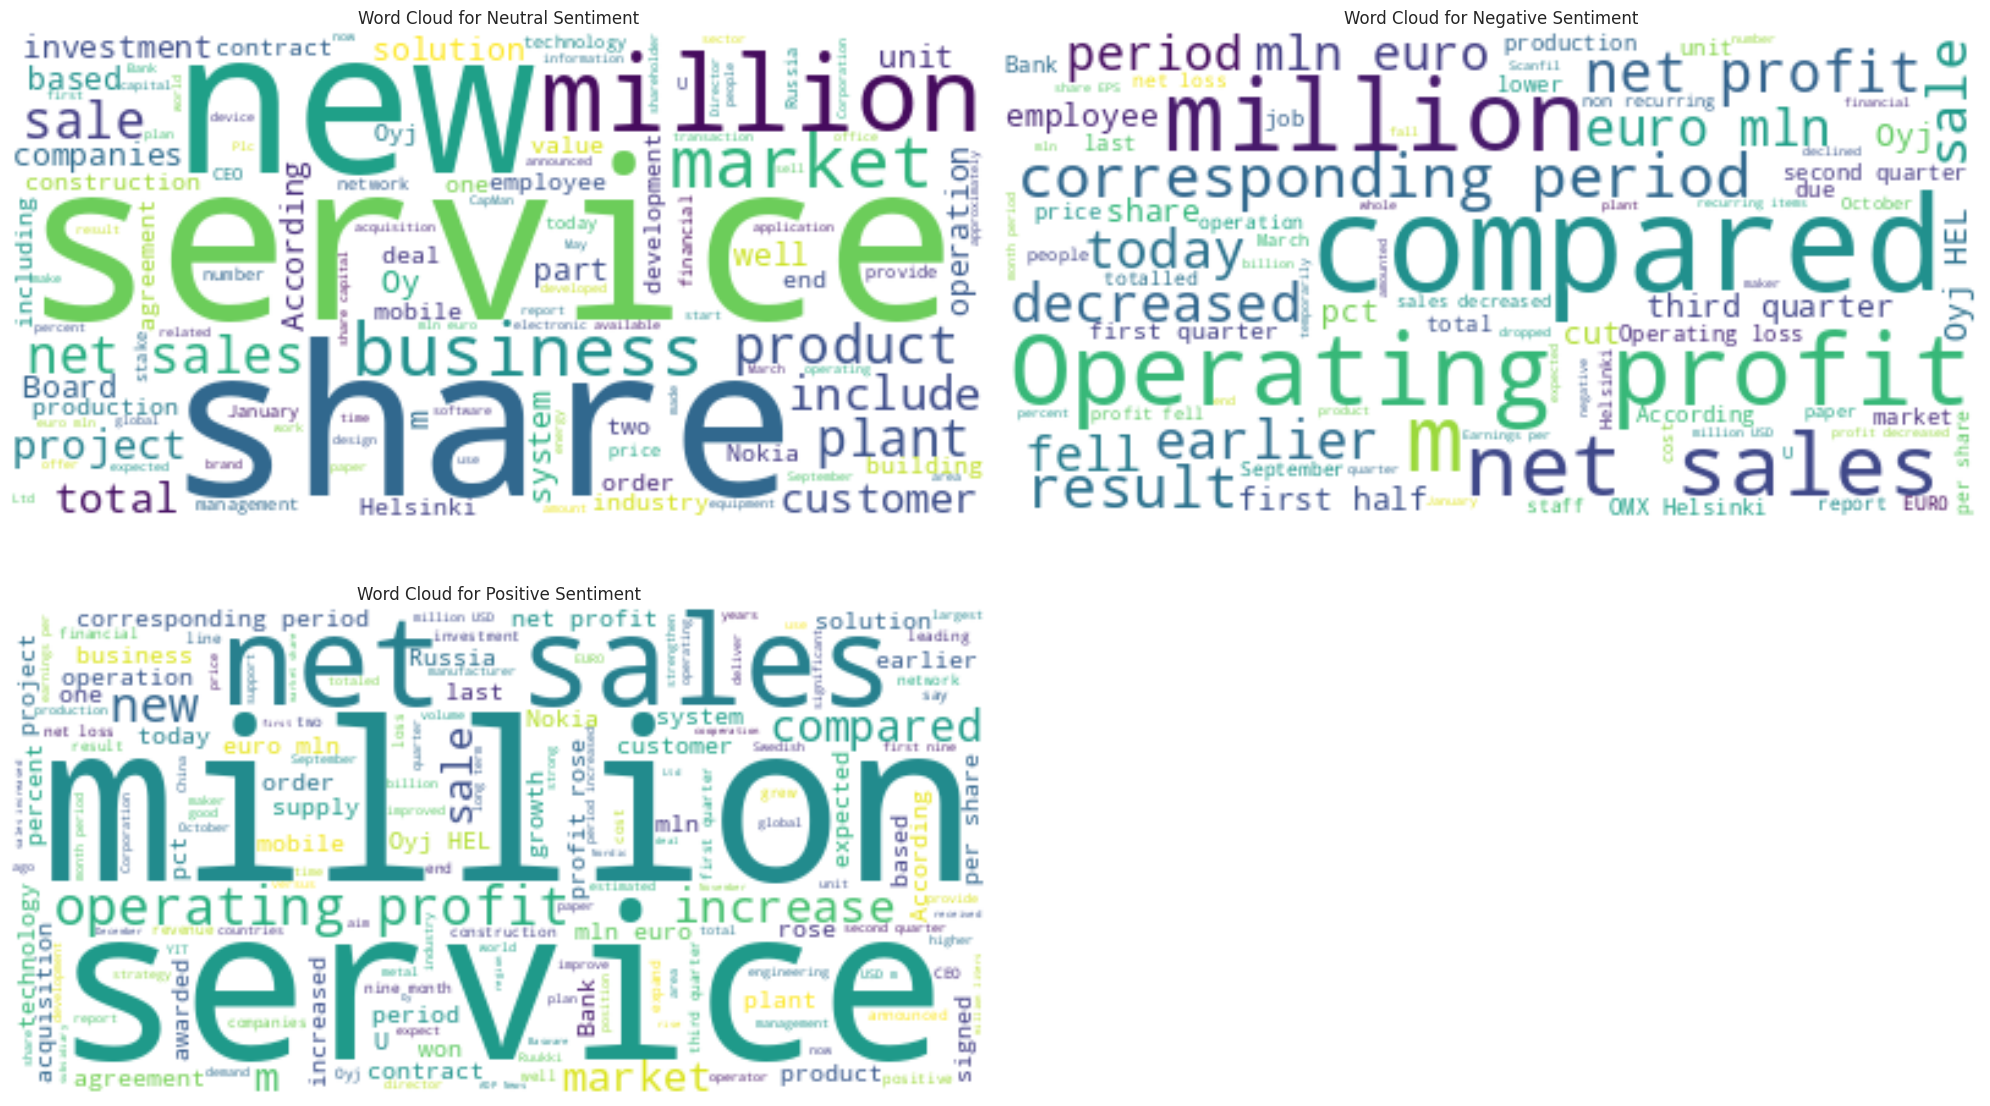

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


additional_stopwords = ["will", "company", "said", "mn", "s","Finland","Finnish","EUR","group","year"]
stopwords = set(STOPWORDS).union(additional_stopwords)

def generate_word_clouds_updated(data):
    sentiments = data['sentiment_hf'].unique()
    
    plt.figure(figsize=(20, 12))
    for i, sentiment in enumerate(sentiments, 1):
        plt.subplot(2, 2, i)
        text = ' '.join(data[data['sentiment_hf'] == sentiment]['news'].tolist())
        wordcloud = WordCloud(background_color='white', max_words=500, contour_width=3, contour_color='steelblue', stopwords=stopwords).generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_word_clouds_updated(data)


### Data Pre-processing for Training

In [15]:
#!python -m spacy download en_core_web_sm

In [16]:
import spacy
import re

nlp = spacy.load("en_core_web_sm")

def advanced_preprocess(text):
    # convert to lowercase
    text = text.lower()
    # remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # remove mentions
    text = re.sub(r'@\w+', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # process the text using spaCy
    doc = nlp(text)
    # lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    # Join the tokens back to a string
    text = ' '.join(tokens)
    return text

data['news'] = data['news'].apply(advanced_preprocess)


In [17]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

X = data['news']
y = data['sentiment_hf']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)
X_train_resampled = pd.Series(X_train_resampled.flatten())

X_combined = pd.concat([X_train_resampled, X_test])
y_combined = pd.concat([y_train_resampled, y_test])

In [18]:
class_dist_before = y_train.value_counts()
class_dist_after_resampling = y_train_resampled.value_counts()
class_dist_combined = y_combined.value_counts()

print(class_dist_before, class_dist_after_resampling, class_dist_combined)


sentiment_hf
neutral     2249
positive    1153
negative     468
Name: count, dtype: int64 sentiment_hf
positive    2249
neutral     2249
negative    2249
Name: count, dtype: int64 sentiment_hf
neutral     2812
positive    2537
negative    2366
Name: count, dtype: int64


In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_vectorized = tfidf_vectorizer.fit_transform(X_combined)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_combined)
X_vectorized.shape, y_encoded.shape

((7715, 7348), (7715,))

### Model Training using SVM

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

X_train_vectorized = tfidf_vectorizer.transform(X_train_resampled)
X_test_vectorized = tfidf_vectorizer.transform(X_test)

svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_vectorized, y_train_resampled)

y_pred = svm_classifier.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.7334710743801653

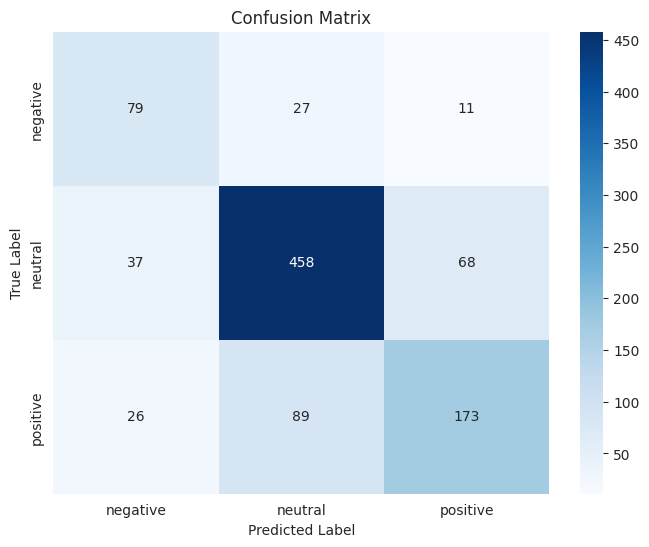

In [21]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': [1, 0.1, 0.01], 
    'kernel': ['linear', 'rbf'], 
}

svm_classifier = SVC(random_state=42)
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_vectorized, y_train_resampled)

best_svm = grid_search.best_estimator_
best_svm.fit(X_train_vectorized, y_train_resampled)

y_pred = best_svm.predict(X_test_vectorized)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Accuracy: 0.746900826446281


In [23]:
from sklearn.metrics import f1_score, confusion_matrix

f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("F1-Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)

F1-Score: 0.7306856357937725

Confusion Matrix:
 [[ 52  50  15]
 [  6 521  36]
 [  9 129 150]]


### Saving as pickle file

In [24]:
import pickle
filename = 'best_svm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_svm, file)

### Pipeline

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import re
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

# Redefine the custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        def advanced_preprocess(text):
            text = text.lower()
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
            text = re.sub(r'@\w+', '', text)
            text = re.sub(r'\d+', '', text)
            doc = self.nlp(text)
            tokens = [token.lemma_ for token in doc if not token.is_stop]
            return ' '.join(tokens)
        
        return X.apply(advanced_preprocess)

pipeline = Pipeline([
    ('text_preprocessing', TextPreprocessor()),
    ('tfidf_vectorizer', TfidfVectorizer(max_features=10000)),
    ('svm_classifier', SVC(kernel='linear', random_state=42))
])

pipeline.fit(X_train_resampled, y_train_resampled)
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

model_filename = "/kaggle/working/sa_svm_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(pipeline, file)



### Reloading pickle file

In [26]:
import pickle
from sklearn.metrics import accuracy_score

model_filename = "/kaggle/working/sa_svm_model.pkl" 

with open(model_filename, 'rb') as file:
    loaded_pipeline_pickle = pickle.load(file)

loaded_y_pred_pickle = loaded_pipeline_pickle.predict(X_test)  # Use raw X_test
loaded_accuracy_pickle = accuracy_score(y_test, loaded_y_pred_pickle)

accuracy, loaded_accuracy_pickle

(0.7324380165289256, 0.7324380165289256)

[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   7.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   6.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   8.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   6.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   8.8s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   6.9s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   6.7s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   8.9s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   4.6s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   7.5s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   4.4s
[CV] END ......................C=1, gamma=0.1, kernel=linear; total time=   4.6s
[CV] END ...................